In [1]:
import pyabc
import fitmulticell as fmc
import scipy as sp
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("bmh")

ERROR:External:Install rpy2 to enable simple support for the R language.


### __Set these before proceeding__

In [2]:
# Specify XML path
CONVERSION_RXN_MODEL = "../_models/ConversionReaction.xml"
# Specify morpheus executable path
MORPHEUS_BIN = "/Applications/Morpheus.app/Contents/MacOS/bin/morpheus"
# Specify database paths
CONVERSION_RXN_NOISY_DB = "sqlite:///../_db/conversion_rxn.db"
CONVERSION_RXN_STOCHASTIC_DB = "sqlite:///../_db/conversion_rxn_stochastic.db"

In [3]:
# Declare parameter mapping
conversion_rxn_par_map = {
    "a": "./Global/System/Constant[@symbol='a']",
    "b": "./Global/System/Constant[@symbol='b']",
#     "c": "./Global/System/Constant[@symbol='c']",
    
}
# Create model instance
conversion_rxn_model = fmc.model.MorpheusModel(
    CONVERSION_RXN_MODEL,
    par_map=conversion_rxn_par_map,
    executable=MORPHEUS_BIN,
    show_stdout=False,
    show_stderr=True,
    raise_on_error=False
)

### True Parameters

In [4]:
# True parameters
conversion_rxn_true_pars = {'a': np.exp(-2.5), 'b': np.exp(-2.0)}
# conversion_rxn_true_pars = {'b': np.exp(-2.0) / 2, 'c': np.exp(-2.0) / 2}
# Bounds for true parameters
conversion_rxn_true_pars_limits = {key: (0.5 * val, 2.0 * val) for key, val in conversion_rxn_true_pars.items()}

In [11]:
conversion_rxn_true_pars_limits = {
    "b": (0.06766764161830635 / 2, 0.2706705664732254 / 2),
    "c": (0.06766764161830635 / 2, 0.2706705664732254 / 2)
}

In [5]:
conversion_rxn_true_pars_limits

{'a': (0.0410424993119494, 0.1641699972477976),
 'b': (0.06766764161830635, 0.2706705664732254)}

### Additive Gaussian noise to measurements

In [6]:
# Generate dummy observed data sampled from true parameters
conversion_rxn_observed_data = conversion_rxn_model.sample(conversion_rxn_true_pars)
# Add Gaussian noise to observed data
sigma = 0.05
conversion_rxn_noisy_measurement_data = {
    "IdSumstat__X2": conversion_rxn_observed_data["IdSumstat__X2"] + sigma * np.random.randn(len(conversion_rxn_observed_data["IdSumstat__time"]))
}

In [7]:
conversion_rxn_observed_data['IdSumstat__X2']

array([0.        , 0.00811991, 0.01606518, 0.02383957, 0.03144675,
       0.03889032, 0.0461738 , 0.05330063, 0.06027418, 0.06709775,
       0.07377456, 0.08030778, 0.08670047, 0.09295568, 0.09907636,
       0.10506539, 0.11092562, 0.11665981, 0.12227067, 0.12776086,
       0.13313297, 0.13838954, 0.14353305, 0.14856594, 0.15349058,
       0.15830931, 0.1630244 , 0.16763809, 0.17215254, 0.1765699 ,
       0.18089225, 0.18512164, 0.18926007, 0.19330949, 0.19727182,
       0.20114893, 0.20494265, 0.20865478, 0.21228708, 0.21584125,
       0.21931898, 0.22272191, 0.22605165, 0.22930978, 0.23249784,
       0.23561733, 0.23866973, 0.24165648, 0.24457899, 0.24743865,
       0.2502368 , 0.25297477, 0.25565386, 0.25827532, 0.26084041,
       0.26335032, 0.26580626, 0.26820937, 0.2705608 , 0.27286166,
       0.27511303, 0.27731598, 0.27947155, 0.28158076, 0.2836446 ,
       0.28566406, 0.28764008, 0.28957361, 0.29146555, 0.2933168 ,
       0.29512823, 0.29690071, 0.29863506, 0.30033212, 0.30199

### Simulation vs. Noisy Measurement plot

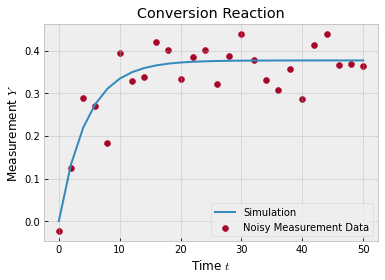

In [7]:
plt.plot(
    conversion_rxn_observed_data["IdSumstat__time"][::20],
    conversion_rxn_observed_data["IdSumstat__X2"][::20],
    color="C0",
    label="Simulation"
)
plt.scatter(
    conversion_rxn_observed_data["IdSumstat__time"][::20],
    conversion_rxn_noisy_measurement_data["IdSumstat__X2"][::20],
    color="C1",
    label="Noisy Measurement Data"
)
plt.xlabel("Time $t$")
plt.ylabel("Measurement $Y$")
plt.title("Conversion Reaction")
plt.legend()
plt.show()

## Uniform acceptor with noisy measurement

In [8]:
# Set prior for parameters
conversion_rxn_noisy_model_prior = pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub - lb) for key, (lb, ub) in conversion_rxn_true_pars_limits.items()}
)

In [9]:
conversion_rxn_noisy_model_prior.get_parameter_names()

['a', 'b']

In [10]:
# Define distance function
def conversion_rxn_distance(simulation, data):
    return np.absolute(data["IdSumstat__X2"] - simulation["IdSumstat__X2"]).sum()

conversion_rxn_abc_uniform = pyabc.ABCSMC(
    models=conversion_rxn_model,
    parameter_priors=conversion_rxn_noisy_model_prior,
    distance_function=conversion_rxn_distance,
    sampler=pyabc.sampler.SingleCoreSampler(),
#     population_size=10,
#     transitions=pyabc.LocalTransition(k_fraction=.3),
#     eps=pyabc.MedianEpsilon(500, median_multiplier=0.7)
)

In [11]:
# Load existing table
conversion_rxn_abc_uniform.load(CONVERSION_RXN_NOISY_DB, 7)
# Create new table
# conversion_rxn_abc_uniform.new(CONVERSION_RXN_NOISY_DB, conversion_rxn_noisy_measurement_data)

In [12]:
conversion_rxn_abc_uniform.history.all_runs()

[<ABCSMC(id=1, start_time=2020-06-24 11:41:51.783580, end_time=2020-07-04 17:33:31.398566)>,
 <ABCSMC(id=2, start_time=2020-07-03 13:08:35.040461, end_time=None)>,
 <ABCSMC(id=3, start_time=2020-07-03 13:11:20.807994, end_time=None)>,
 <ABCSMC(id=4, start_time=2020-07-03 13:11:41.135825, end_time=None)>,
 <ABCSMC(id=5, start_time=2020-07-03 13:15:37.089446, end_time=2020-07-03 13:15:45.147173)>,
 <ABCSMC(id=6, start_time=2020-07-03 13:16:34.564635, end_time=None)>,
 <ABCSMC(id=7, start_time=2020-07-04 12:02:47.725090, end_time=2020-07-04 20:51:16.048603)>,
 <ABCSMC(id=8, start_time=2020-07-04 16:21:56.918937, end_time=None)>]

In [13]:
history_uniform = conversion_rxn_abc_uniform.run(minimum_epsilon=0.1, max_nr_populations=0)

INFO:Epsilon:initial epsilon is 20.270685967232975
INFO:History:Done <ABCSMC(id=7, start_time=2020-07-04 12:02:47.725090, end_time=2020-07-06 21:33:03.080591)>


### Epsilon vs. Population (for uniform acceptor)

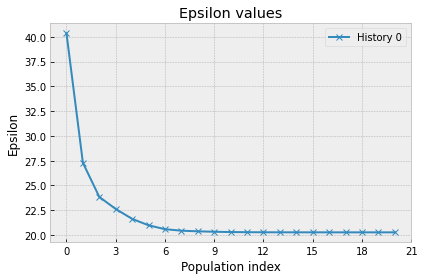

In [14]:
pyabc.visualization.plot_epsilons(history_uniform)
plt.show()

### KDE Matrix (for uniform acceptor)

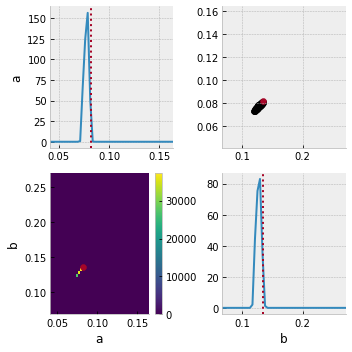

In [36]:
pyabc.visualization.plot_kde_matrix_highlevel(
    history_uniform, t=9,
    refval=conversion_rxn_true_pars,
    limits=conversion_rxn_true_pars_limits
)
plt.show()

### $a$ and $b$ posterior development (for uniform acceptor)

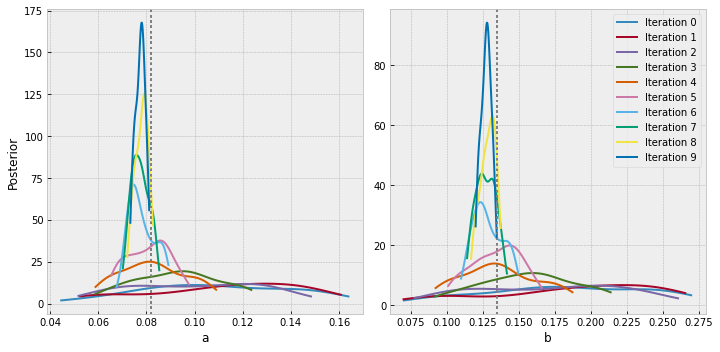

In [31]:
fig, ax = plt.subplots(1,2)
# for t in range(history_uniform.max_t + 1):
for t in range(10):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_uniform, x="a", t=t,
        refval=conversion_rxn_true_pars, refval_color='grey',
        ax=ax[0], label=f"Iteration {t}")
    pyabc.visualization.plot_kde_1d_highlevel(
        history_uniform, x="b", t=t,
        refval=conversion_rxn_true_pars, refval_color='grey',
        ax=ax[1], label=f"Iteration {t}")
ax[1].set_xlabel("b")
ax[1].set_ylabel(None)
ax[1].legend()
fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

### 2D KDE (for uniform acceptor)

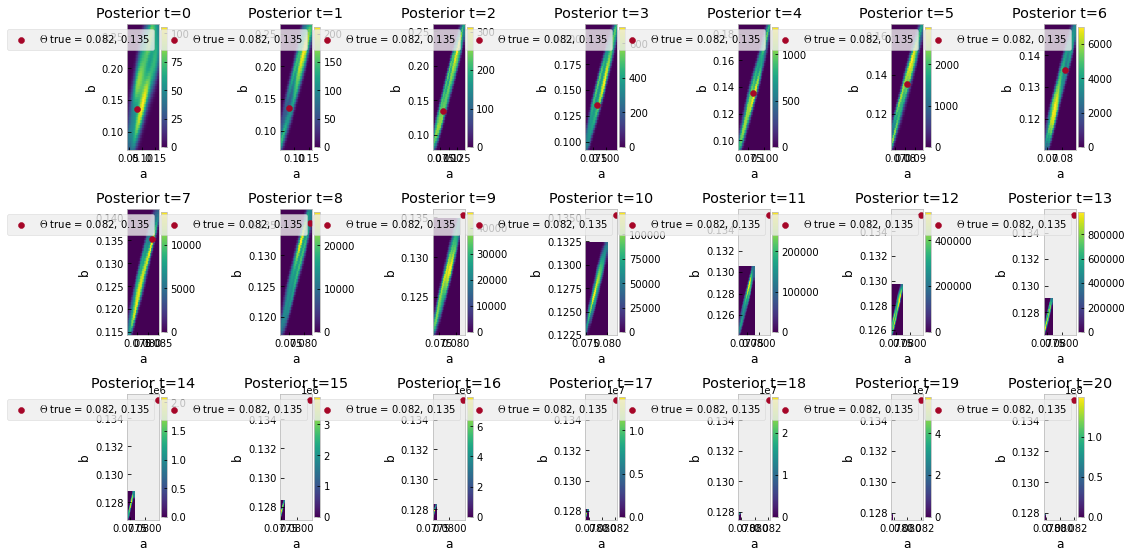

In [18]:
fig = plt.figure(figsize=(15,10))
for t in range(history_uniform.max_t+1):
    ax = fig.add_subplot(4, np.ceil(history_uniform.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_2d_highlevel(
        history_uniform, x="a", y="b", t=t, ax=ax
    )
    ax.scatter([conversion_rxn_true_pars["a"]], [conversion_rxn_true_pars["b"]], color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    conversion_rxn_true_pars["a"], conversion_rxn_true_pars["b"]))
    ax.set_title("Posterior t={}".format(t))

    ax.legend()
fig.tight_layout()

## Stochastic acceptor with noisy measurement

In [19]:
conversion_rxn_abc_stochastic = pyabc.ABCSMC(
    models=conversion_rxn_model,
    parameter_priors=conversion_rxn_noisy_model_prior,
    sampler=pyabc.sampler.SingleCoreSampler(),
    distance_function=pyabc.IndependentNormalKernel(keys=["IdSumstat__X2"], var=sigma**2),
    eps=pyabc.Temperature(),
    acceptor=pyabc.StochasticAcceptor()
)
# conversion_rxn_abc_stochastic.new(CONVERSION_RXN_STOCHASTIC_DB, conversion_rxn_noisy_measurement_data)
conversion_rxn_abc_stochastic.load(CONVERSION_RXN_STOCHASTIC_DB, 2)

In [20]:
conversion_rxn_abc_stochastic.history.all_runs()

[<ABCSMC(id=1, start_time=2020-07-04 17:23:50.506737, end_time=None)>,
 <ABCSMC(id=2, start_time=2020-07-04 17:25:39.639653, end_time=2020-07-04 17:32:36.560284)>]

In [21]:
history_stochastic = conversion_rxn_abc_stochastic.run(minimum_epsilon=0.1, max_nr_populations=0)

INFO:History:Done <ABCSMC(id=2, start_time=2020-07-04 17:25:39.639653, end_time=2020-07-06 21:36:42.029244)>


### Epsilon vs. Population (for stochastic acceptor)

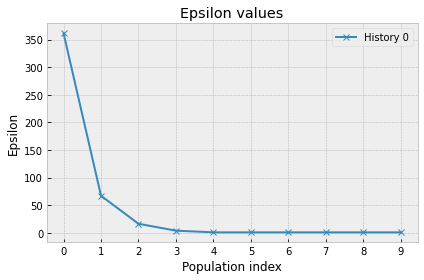

In [22]:
pyabc.visualization.plot_epsilons(history_stochastic)
plt.show()

### KDE Matrix (for stochastic acceptor)

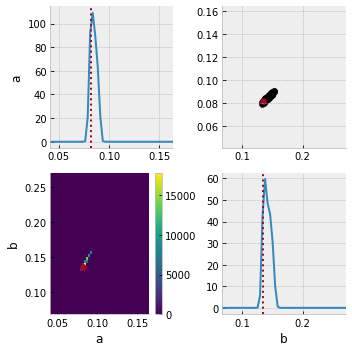

In [37]:
pyabc.visualization.plot_kde_matrix_highlevel(
    history_stochastic, t=9,
    refval=conversion_rxn_true_pars,
    limits=conversion_rxn_true_pars_limits
)
plt.show()

### $a$ and $b$ posterior development (for stochastic acceptor)

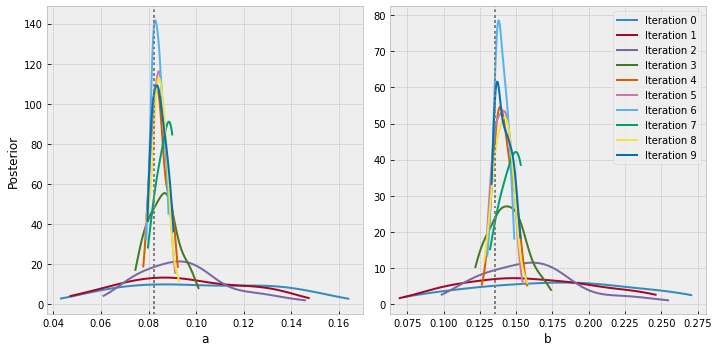

In [32]:
fig, ax = plt.subplots(1,2)
for t in range(history_stochastic.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_stochastic, x="a", t=t,
        refval=conversion_rxn_true_pars, refval_color='grey',
        ax=ax[0], label=f"Iteration {t}")
    pyabc.visualization.plot_kde_1d_highlevel(
        history_stochastic, x="b", t=t,
        refval=conversion_rxn_true_pars, refval_color='grey',
        ax=ax[1], label=f"Iteration {t}")
ax[1].set_xlabel("b")
ax[1].set_ylabel(None)
ax[1].legend()
fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

### 2D KDE (for stochastic acceptor)

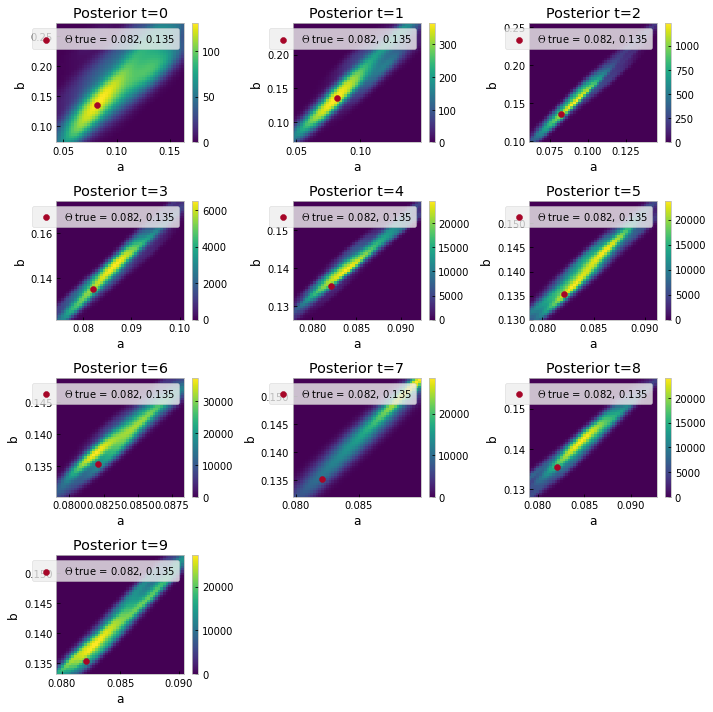

In [26]:
fig = plt.figure(figsize=(10,10))
for t in range(history_stochastic.max_t+1):
    ax = fig.add_subplot(4, np.ceil(history_stochastic.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_2d_highlevel(
        history_stochastic, x="a", y="b", t=t, ax=ax
    )
    ax.scatter([conversion_rxn_true_pars["a"]], [conversion_rxn_true_pars["b"]], color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    conversion_rxn_true_pars["a"], conversion_rxn_true_pars["b"]))
    ax.set_title("Posterior t={}".format(t))

    ax.legend()
fig.tight_layout()

### Comparison of two approaches for noise measurement

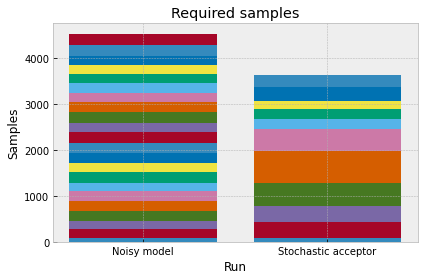

In [27]:
histories = [history_uniform, history_stochastic]
labels = ["Noisy model", "Stochastic acceptor"]

pyabc.visualization.plot_sample_numbers(histories, labels)
plt.show()